# **빅데이터 개론 Lab 12 - 의사 결정 트리(Decision Tree)**

참고자료 : https://www.notion.so/TA-2689a38b5289413a82671d3956fea103

- - -




### **<의사 결정 트리(Decision Tree)>**

* 기계학습 중 하나로 특정 항목에 대한 의사 결정 규칙 (Decision rule)을 나무 형태로 분류해 나가는 분석 기법

* 예를 들어, 타이타닉 호 탑승자의 성별, 나이, 자녀의 수를 이용해서 생존 확률을 아래와 같이 구분해 나가는 것


``` 예시 ```

<img src="https://i0.wp.com/www.dodomira.com/wp-content/uploads/2016/04/CART_tree_titanic_survivors_KOR.png?w=350" width="400" height="300">

* 가장 큰 장점은 분석 과정이 직관적이고 이해하기 쉬움

* 인공신경망 분석의 경우 결과에 대한 설명을 이해하기 어려운 대표적인 블랙박스 모델인 반면, 의사결정나무 기법은 분석 과정을 실제로 눈으로 관측할 수 있기 때문에 대표적인 ``화이트박스 모델``.

* 수치형(Numeric, Integer)/범주형(Factor) 변수를 모두 사용할 수 있다는 점, 계산 비용이 낮아 대규모의 데이터 셋에서도 비교적 빠르게 연산이 가능하다는 점이 장점.

* 분석 방법에는 통계학에 기반한 CART 및 CHAID 알고리즘이나, 기계학습 계열인 ID3, C4.5, C5.0 등의 알고리즘이 존재

### **R의 의사결정트리 분석 패키지 비교 (Packages for Decision Tree in R)**

* tree, rpart, party


1. tree 패키지는 binary recursive partitioning을,  rpart 패키지는 CART(classification and regression trees) 사용

  * 엔트로피(entropy, tree 패키지), 지니계수(gini index, rpart 패키지)를 기준으로 가지치기를 할 변수를 결정하기 때문에 상대적으로 연산 속도는 빠르지만 과적합화의 위험성 존재. ``따라서 두 패키지를 사용할 경우에는 Pruning 과정을 거쳐서 의사결정트리를 최적화 하는 과정이 필요``

2. party 패키지는 Unbiased recursive partitioning based on permutation tests 방법론을 사용

  * p-test를 거친 Significance를 기준으로 가지치기를 할 변수를 결정하기 때문에 biased 될 위험이 없어 별도로 Pruning할 필요가 없다는 장점 존재. ``하지만, 입력 변수의 레벨이 31개 까지로 제한되어 있다는 단점이 있음``

* **알고리즘 비교**

<img src="https://github.com/Jin0331/TA/blob/master/image/algorithm_dt.png?raw=true" width="600" height="450">

출처 : https://m.blog.naver.com/PostView.nhn?blogId=tjdudwo93&logNo=221041168345&proxyReferer=https:%2F%2Fwww.google.com%2F


In [1]:
install.packages(c("tidyverse", "data.table", "caret", "e1071", "rpart"))
library(tidyverse)
library(data.table)
library(caret)
library(rpart)

options(repr.plot.width=10, repr.plot.height=10)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘plyr’, ‘ModelMetrics’, ‘reshape2’, ‘recipes’, ‘pROC’


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




#### **A. 예제 1 - rpart 패키지 이용**

---


1. **Heart Disease Data** 

https://archive.ics.uci.edu/ml/datasets/heart+disease

* 변수 설명

```
Age : age in years
Sex: sex (1 = male; 0 = female) # Factor
ChestPain : (typical angina, atypical angina, non-anginal pain, asymptomatic # Factor
RestBP(혈압) : resting blood pressure
Chol(콜레스테롤 수치) : serum cholestoral in mg/dl
Fbs(혈당) : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) # Factor
Restecg(심전도) : (0 = normal, 1 = having ST-T wave abnormality, 2 =  showing probable or definite left ventricular hypertrophy by Estes' criteria) # Factor
MaxHR : maximum heart rate achieved
ExAng(협심증?): exercise induced angina (1 = yes; 0 = no) # Factor
Oldpeak = ST depression induced by exercise relative to rest
Slope: the slope of the peak exercise ST segment(1 = upsloping, 2 = flat, 3 = downsloping) # Factor
Ca: number of major vessels (0-3) colored by flourosopy # Factor
Thal: 3 = normal; 6 = fixed defect; 7 = reversable defect # Factor

# the predicted attribute(반응변수)

AHD : diagnosis of heart disease (angiographic disease status)(0 = < 50% diameter narrowing, 1 =  > 50% diameter narrowing)

# http://archive.ics.uci.edu/ml/datasets/heart+Disease


In [2]:
heart_df <- fread("https://raw.githubusercontent.com/Jin0331/TA/master/data/heart/Heart.csv") %>% 
  as_tibble()

str(heart_df)

tibble [303 × 15] (S3: tbl_df/tbl/data.frame)
 $ V1       : int [1:303] 1 2 3 4 5 6 7 8 9 10 ...
 $ Age      : int [1:303] 63 67 67 37 41 56 62 57 63 53 ...
 $ Sex      : int [1:303] 1 1 1 1 0 1 0 0 1 1 ...
 $ ChestPain: chr [1:303] "typical" "asymptomatic" "asymptomatic" "nonanginal" ...
 $ RestBP   : int [1:303] 145 160 120 130 130 120 140 120 130 140 ...
 $ Chol     : int [1:303] 233 286 229 250 204 236 268 354 254 203 ...
 $ Fbs      : int [1:303] 1 0 0 0 0 0 0 0 0 1 ...
 $ RestECG  : int [1:303] 2 2 2 0 2 0 2 0 2 2 ...
 $ MaxHR    : int [1:303] 150 108 129 187 172 178 160 163 147 155 ...
 $ ExAng    : int [1:303] 0 1 1 0 0 0 0 1 0 1 ...
 $ Oldpeak  : num [1:303] 2.3 1.5 2.6 3.5 1.4 0.8 3.6 0.6 1.4 3.1 ...
 $ Slope    : int [1:303] 3 2 2 3 1 1 3 1 2 3 ...
 $ Ca       : int [1:303] 0 3 2 0 0 0 2 0 1 0 ...
 $ Thal     : chr [1:303] "fixed" "normal" "reversable" "normal" ...
 $ AHD      : chr [1:303] "No" "Yes" "Yes" "No" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [3]:
heart_df %>% str()

tibble [303 × 15] (S3: tbl_df/tbl/data.frame)
 $ V1       : int [1:303] 1 2 3 4 5 6 7 8 9 10 ...
 $ Age      : int [1:303] 63 67 67 37 41 56 62 57 63 53 ...
 $ Sex      : int [1:303] 1 1 1 1 0 1 0 0 1 1 ...
 $ ChestPain: chr [1:303] "typical" "asymptomatic" "asymptomatic" "nonanginal" ...
 $ RestBP   : int [1:303] 145 160 120 130 130 120 140 120 130 140 ...
 $ Chol     : int [1:303] 233 286 229 250 204 236 268 354 254 203 ...
 $ Fbs      : int [1:303] 1 0 0 0 0 0 0 0 0 1 ...
 $ RestECG  : int [1:303] 2 2 2 0 2 0 2 0 2 2 ...
 $ MaxHR    : int [1:303] 150 108 129 187 172 178 160 163 147 155 ...
 $ ExAng    : int [1:303] 0 1 1 0 0 0 0 1 0 1 ...
 $ Oldpeak  : num [1:303] 2.3 1.5 2.6 3.5 1.4 0.8 3.6 0.6 1.4 3.1 ...
 $ Slope    : int [1:303] 3 2 2 3 1 1 3 1 2 3 ...
 $ Ca       : int [1:303] 0 3 2 0 0 0 2 0 1 0 ...
 $ Thal     : chr [1:303] "fixed" "normal" "reversable" "normal" ...
 $ AHD      : chr [1:303] "No" "Yes" "Yes" "No" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [4]:
# 결측값 있는지 없는지 확인
# Ca에 NA값 있음

heart_df %>% summary()

       V1             Age             Sex          ChestPain        
 Min.   :  1.0   Min.   :29.00   Min.   :0.0000   Length:303        
 1st Qu.: 76.5   1st Qu.:48.00   1st Qu.:0.0000   Class :character  
 Median :152.0   Median :56.00   Median :1.0000   Mode  :character  
 Mean   :152.0   Mean   :54.44   Mean   :0.6799                     
 3rd Qu.:227.5   3rd Qu.:61.00   3rd Qu.:1.0000                     
 Max.   :303.0   Max.   :77.00   Max.   :1.0000                     
                                                                    
     RestBP           Chol            Fbs            RestECG      
 Min.   : 94.0   Min.   :126.0   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:120.0   1st Qu.:211.0   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :130.0   Median :241.0   Median :0.0000   Median :1.0000  
 Mean   :131.7   Mean   :246.7   Mean   :0.1485   Mean   :0.9901  
 3rd Qu.:140.0   3rd Qu.:275.0   3rd Qu.:0.0000   3rd Qu.:2.0000  
 Max.   :200.0   Max.   :564.0   Max.   :1.000

* Sex, ChestPain, Fbs, RestECG, ExAng, Slope, Ca, Thal, AHD ---> Factor

In [5]:
# 범주형 변수를 Factor로 바꿔주기

heart_df$ChestPain %>% unique() 

[1] "typical"      "asymptomatic" "nonanginal"   "nontypical"

In [6]:
heart_df$Fbs %>% unique()

[1] 1 0

In [7]:
heart_df$RestECG %>% unique()

[1] 2 0 1

In [8]:
heart_df$ExAng %>% unique()

[1] 0 1

In [9]:
heart_df$Slope %>% unique()

[1] 3 2 1

In [10]:
heart_df$Ca %>% unique()

[1]  0  3  2  1 NA

In [11]:
heart_df$Thal %>% unique()

[1] "fixed"      "normal"     "reversable" NA

In [12]:
heart_df$AHD %>% unique()

[1] "No"  "Yes"

* mutate를 이용한 데이터 타입 변경(int or chr ---> factor)

In [13]:
# factor로 형변환

heart_df <- heart_df %>% 
 mutate_at(`.vars` = c("Sex", "ChestPain", "Fbs", "RestECG", "ExAng", "Slope", "Ca", "Thal", "AHD"), `.funs` = as.factor)
heart_df %>% str()

tibble [303 × 15] (S3: tbl_df/tbl/data.frame)
 $ V1       : int [1:303] 1 2 3 4 5 6 7 8 9 10 ...
 $ Age      : int [1:303] 63 67 67 37 41 56 62 57 63 53 ...
 $ Sex      : Factor w/ 2 levels "0","1": 2 2 2 2 1 2 1 1 2 2 ...
 $ ChestPain: Factor w/ 4 levels "asymptomatic",..: 4 1 1 2 3 3 1 1 1 1 ...
 $ RestBP   : int [1:303] 145 160 120 130 130 120 140 120 130 140 ...
 $ Chol     : int [1:303] 233 286 229 250 204 236 268 354 254 203 ...
 $ Fbs      : Factor w/ 2 levels "0","1": 2 1 1 1 1 1 1 1 1 2 ...
 $ RestECG  : Factor w/ 3 levels "0","1","2": 3 3 3 1 3 1 3 1 3 3 ...
 $ MaxHR    : int [1:303] 150 108 129 187 172 178 160 163 147 155 ...
 $ ExAng    : Factor w/ 2 levels "0","1": 1 2 2 1 1 1 1 2 1 2 ...
 $ Oldpeak  : num [1:303] 2.3 1.5 2.6 3.5 1.4 0.8 3.6 0.6 1.4 3.1 ...
 $ Slope    : Factor w/ 3 levels "1","2","3": 3 2 2 3 1 1 3 1 2 3 ...
 $ Ca       : Factor w/ 4 levels "0","1","2","3": 1 4 3 1 1 1 3 1 2 1 ...
 $ Thal     : Factor w/ 3 levels "fixed","normal",..: 1 2 3 2 2 2 2 2 3 3 .

* **train-test split**

In [14]:
# train set(0.7)과 test set(0.3)으로 분류하기
# y= 범위(반응변수)

library(caret) 
set.seed(31)

index <- createDataPartition(y = heart_df$AHD, p = 0.7, list = FALSE) 
head(index, 20)

Resample1
2
3
4
5
6
7
9
11
12
14


In [15]:
# 분류된것을 확인

train <- heart_df[index, ]
test <- heart_df[-index, ]

train %>% show()
test %>% show()

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


# A tibble: 213 x 15
      V1   Age Sex   ChestPain RestBP  Chol Fbs   RestECG MaxHR ExAng Oldpeak
   <int> <int> <fct> <fct>      <int> <int> <fct> <fct>   <int> <fct>   <dbl>
 1     2    67 1     asymptom…    160   286 0     2         108 1         1.5
 2     3    67 1     asymptom…    120   229 0     2         129 1         2.6
 3     4    37 1     nonangin…    130   250 0     0         187 0         3.5
 4     5    41 0     nontypic…    130   204 0     2         172 0         1.4
 5     6    56 1     nontypic…    120   236 0     0         178 0         0.8
 6     7    62 0     asymptom…    140   268 0     2         160 0         3.6
 7     9    63 1     asymptom…    130   254 0     2         147 0         1.4
 8    11    57 1     asymptom…    140   192 0     0         148 0         0.4
 9    12    56 0     nontypic…    140   294 0     2         153 0         1.3
10    14    44 1     nontypic…    120   263 0     0         173 0         0  
# … with 203 more rows, and 4 more variable

* **train 데이터 및 rpart를 이용한 의사결정트리(Decision Tree) 모델 생성**

![png](https://github.com/Jin0331/TA/blob/master/image/rpart_help.png?raw=true)

In [16]:
# rpart 패키지 이용해서 결정함수 구하기 
# 반응변수 ~ 설명변수
# method => 범주형이면 class, 회귀형이면 anova


library(rpart)
AHD_detection <- rpart(formula = AHD ~ ., data = train, method = "class")


In [17]:
# 구조를 출력
# CP => 복잡도 => 분개횟수가 늘어날수록(노드가 내려갈 수 록) 복잡도는 줄어든다. -> 복잡도가 미세하게 줄어들면 나눌필요 없음
# Variable importance => 어떤것이 반응변수에 영향을 많이 끼치는지 알 수 있다. -> chestpain이 제일 영향 많이 끼침


summary(AHD_detection)

Call:
rpart(formula = AHD ~ ., data = train, method = "class")
  n= 213 

          CP nsplit rel error    xerror       xstd
1 0.50000000      0 1.0000000 1.0000000 0.07422429
2 0.06632653      1 0.5000000 0.5714286 0.06555834
3 0.05102041      3 0.3673469 0.5816327 0.06593012
4 0.01020408      4 0.3163265 0.4795918 0.06175713
5 0.01000000      5 0.3061224 0.5102041 0.06311941

Variable importance
ChestPain      Thal   Oldpeak     ExAng     MaxHR        Ca       Age     Slope 
       23        15        14        12        10         8         5         5 
      Sex        V1      Chol 
        4         2         2 

Node number 1: 213 observations,    complexity param=0.5
  predicted class=No   expected loss=0.4600939  P(node) =1
    class counts:   115    98
   probabilities: 0.540 0.460 
  left son=2 (112 obs) right son=3 (101 obs)
  Primary splits:
      ChestPain splits as  RLLL,      improve=30.65416, (0 missing)
      Ca        splits as  LRRR,      improve=28.11315, (4 missing

* plotting

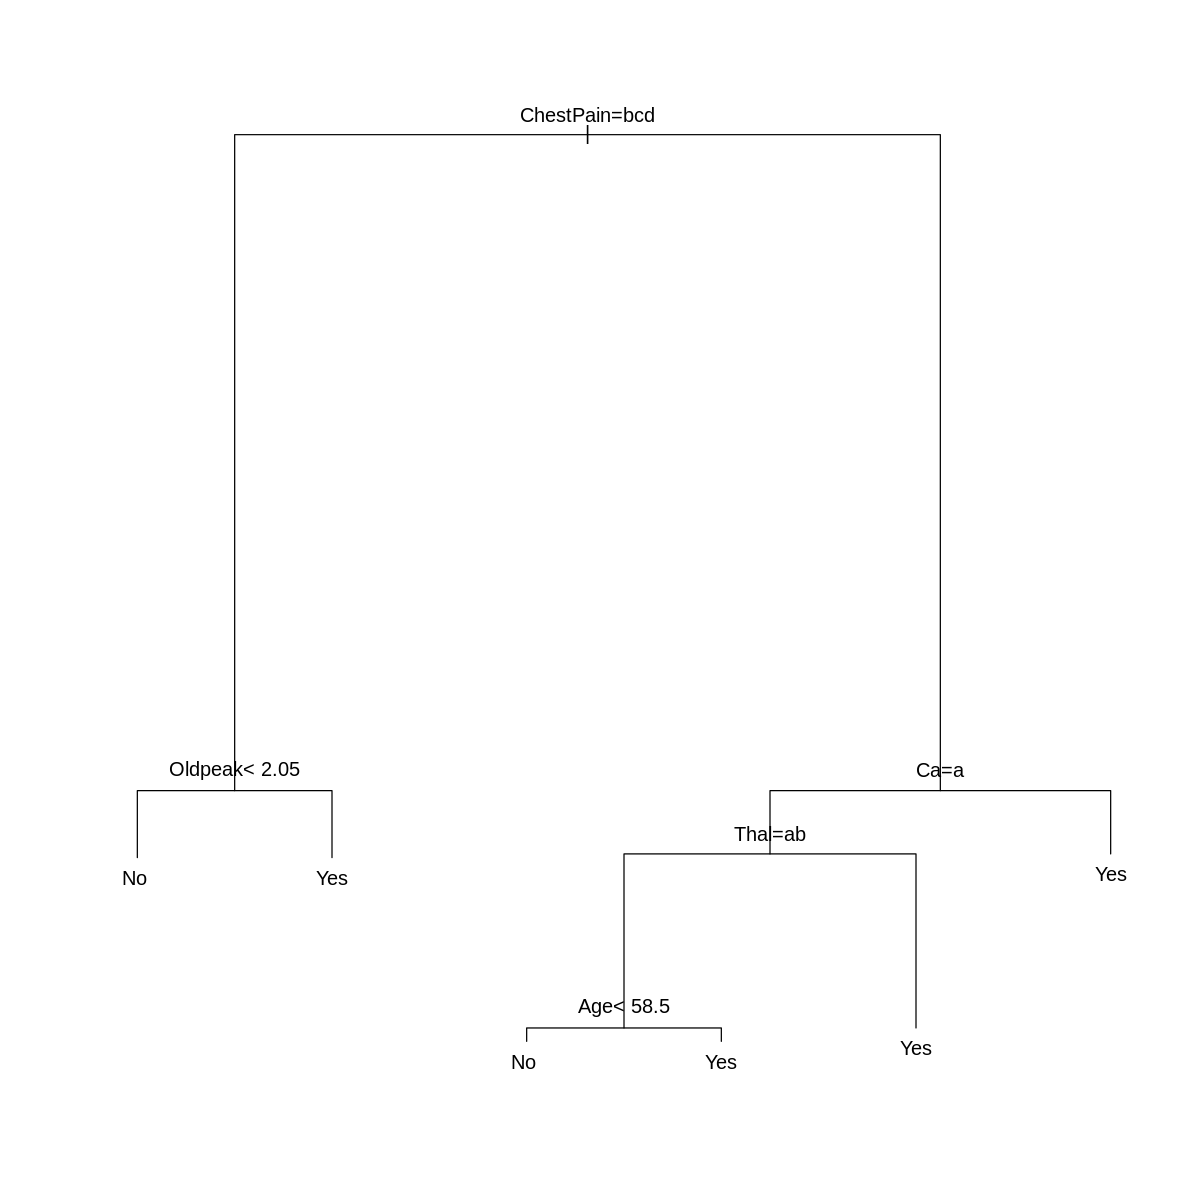

In [18]:
# 결정함수 모델 넣어주면 알아서 그려줌

plot(AHD_detection)
text(AHD_detection)

* 심미적 plotting(?)

In [19]:
# 시각화를 꾸며주는 패키지

install.packages(c("rattle", "rpart.plot"))

library(rattle)
library(rpart.plot)
library(RColorBrewer)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘XML’


Loading required package: bitops

Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.



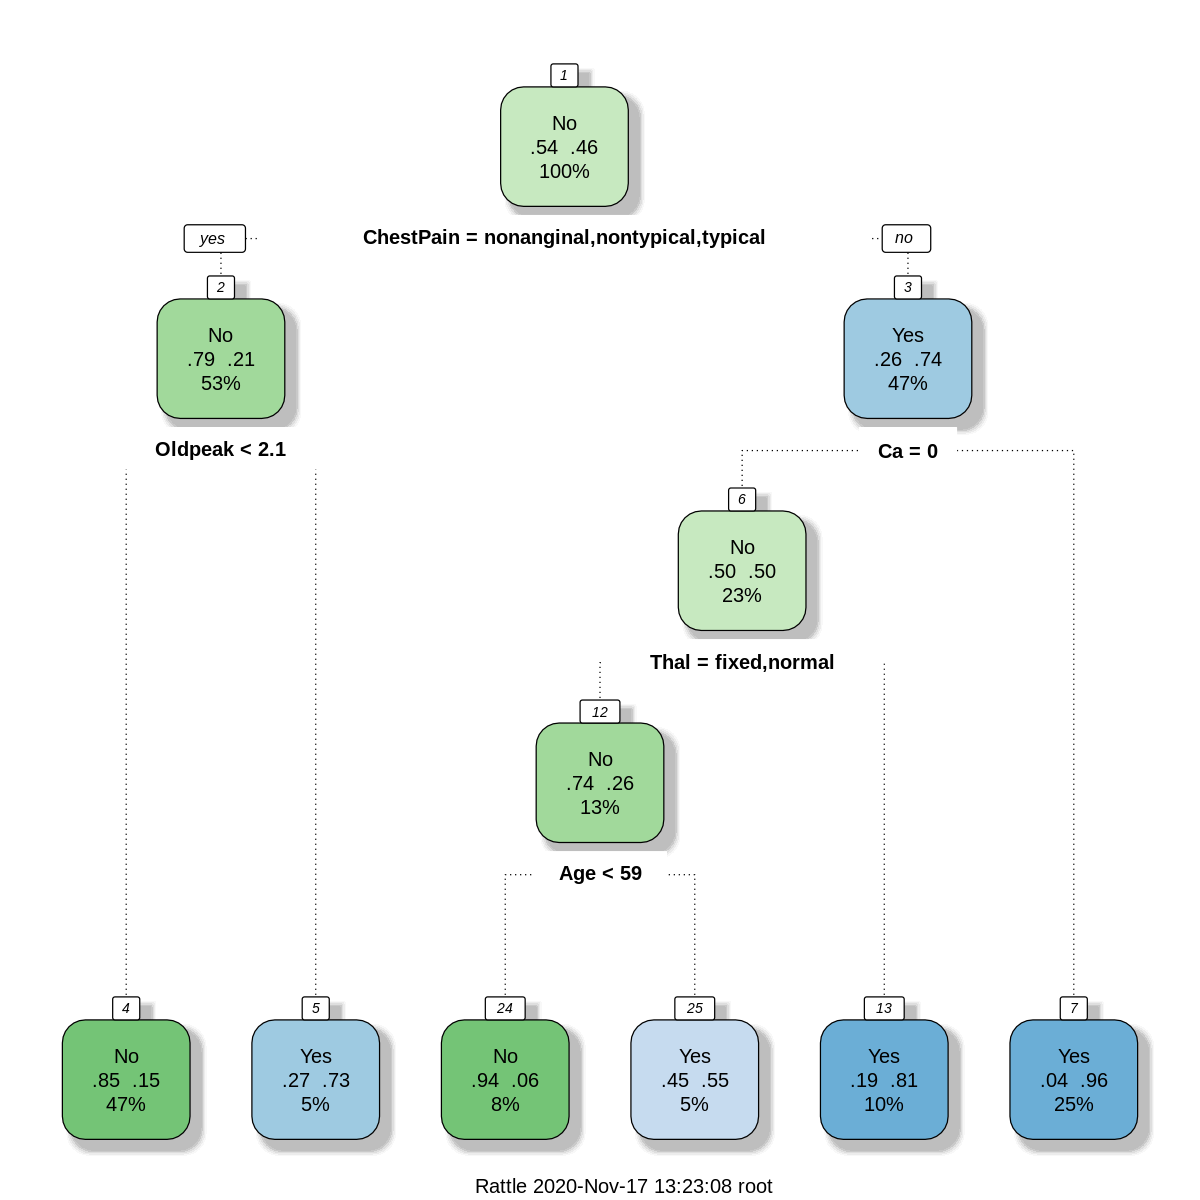

In [20]:
# 함수에 모델만 넣어주면 됨 -> 그래프를 꾸밀수 있음
# 밑에 텍스트 꼭 읽기 

fancyRpartPlot(AHD_detection)

A. node의 성질

* 박스 가장 위의 “No”라는 구분자는 해당 node는 “no”(음성)라고 구분될 수 있다는 것을 의미. 같은 원리로 가장 아랫줄의 제일 오른쪽  node(7번)를 보면 "yes". 해당 node에 속하는 관측치(여기서는 환자들)은 양성그룹으로 분류

B. node의 순도

* node의 순도(지니 불순도)는 node의 색상(진하기) 및 두번째 열의 숫자로 확인. 7번 node는 0.04, 0.96으로 표시되어 있음. 이 의미는 이 node에 속하는 관측치 중 4%는 no 96%는 yes에 속한다는 의미. 

C. node가 전체에서 차지하는 비중

* 7번 node로 돌아가서, 가장 아랫쪽의 숫자 25%가 의미하는 것은 해당 node가 전체 데이터 셋에서 차지하는 비중. 전체의 25%의 관측치(환자)가 이 node에 속한다고 볼 수 있음.

```
종합적으로 해석해 보면 7번 node로 분류된 환자는 전체의 25%로,
ChestPain이 'typical''nonanginal''nontypical'이 아니면서, 
Ca가 0이 아닌 환자들로 구성된 이 그룹은 96%의 확률로 심장병 양성에 속한다는 해석을 할 수 있다. 

```




* rpart::printcp을 이용한 가지치기(pruning)

In [21]:
# 가지치기 => 필요없는 특성을 제거해준다. -> 복잡도 줄여주기 위해서 -> 과대적합 안되기 위해 
# 가지치기는 CP와 xerror 만 있으면 된다. 

rpart::printcp(AHD_detection)


Classification tree:
rpart(formula = AHD ~ ., data = train, method = "class")

Variables actually used in tree construction:
[1] Age       Ca        ChestPain Oldpeak   Thal     

Root node error: 98/213 = 0.46009

n= 213 

        CP nsplit rel error  xerror     xstd
1 0.500000      0   1.00000 1.00000 0.074224
2 0.066327      1   0.50000 0.57143 0.065558
3 0.051020      3   0.36735 0.58163 0.065930
4 0.010204      4   0.31633 0.47959 0.061757
5 0.010000      5   0.30612 0.51020 0.063119


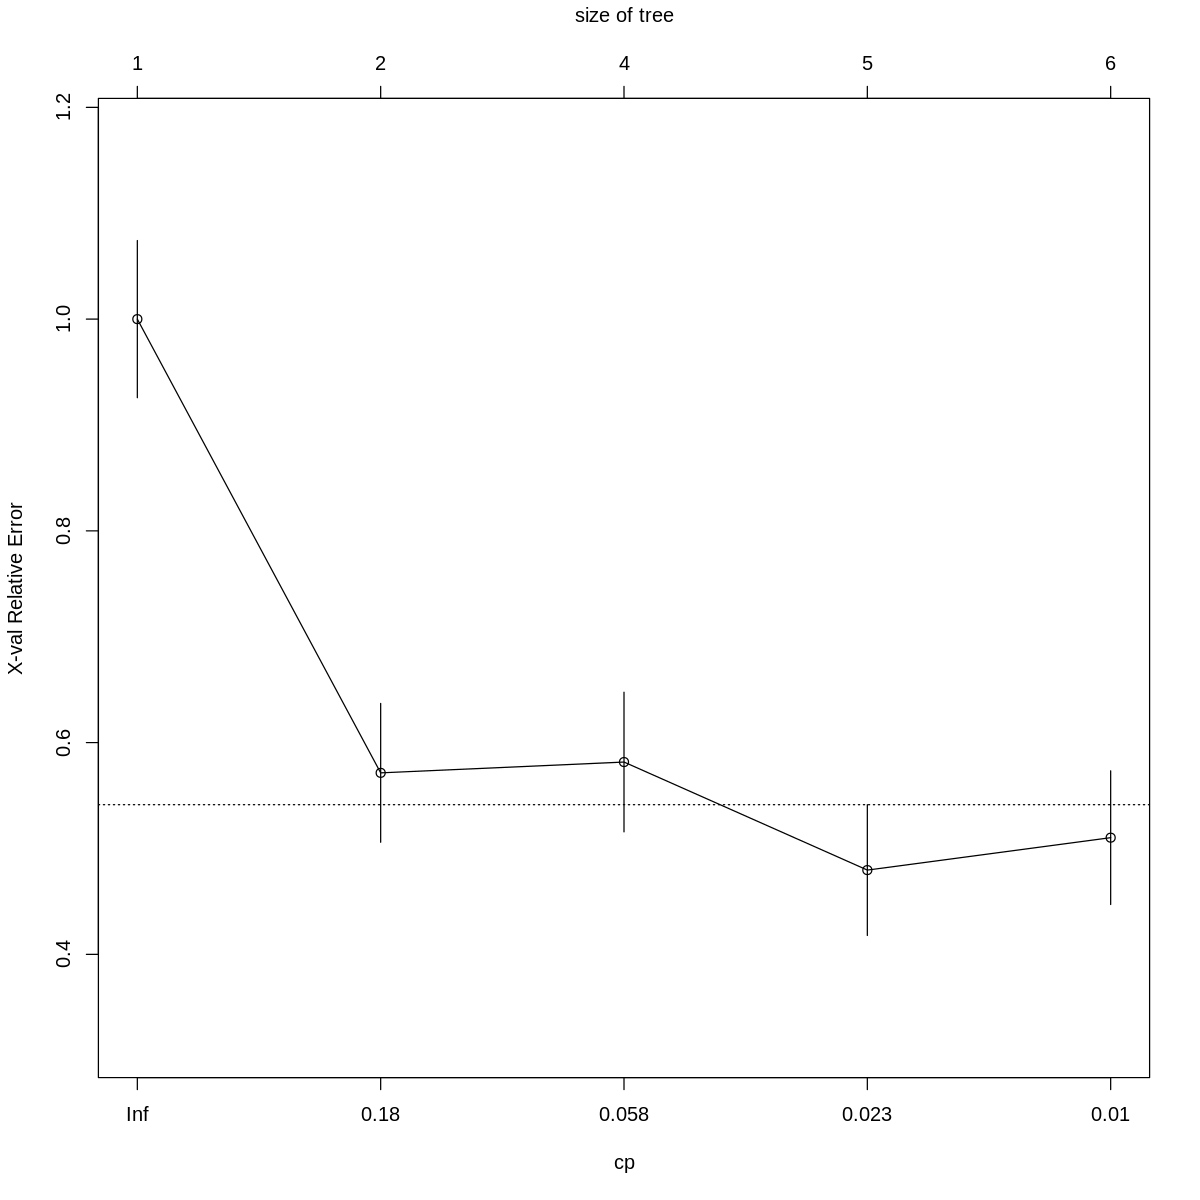

In [22]:
# xerror가 가장 낮은 CP를 고르면 됨
# 0.023을 고를 수 있다. -> 이때 tree size는 5라는 것을 알 수 있다.

plotcp(AHD_detection)

  - xerror(cross validation error)가 최소가 되는 CP를 선택

In [23]:
# filter를 통해 xerror의 최솟값을 가져온다. 

AHD_detection$cptable %>% as_tibble() %>%
  filter(xerror == min(xerror))

min_xerror_cp <- AHD_detection$cptable %>% as_tibble() %>%
  filter(xerror == min(xerror)) %>% pull(CP)#pull을 통해 cp값만 빼온다. 

CP,nsplit,rel error,xerror,xstd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.01020408,4,0.3163265,0.4795918,0.06175713


In [24]:
# xerror가 최소가 되는 CP값이 들어가있는것을 확인할 수 있다.

min_xerror_cp

[1] 0.01020408

* prune

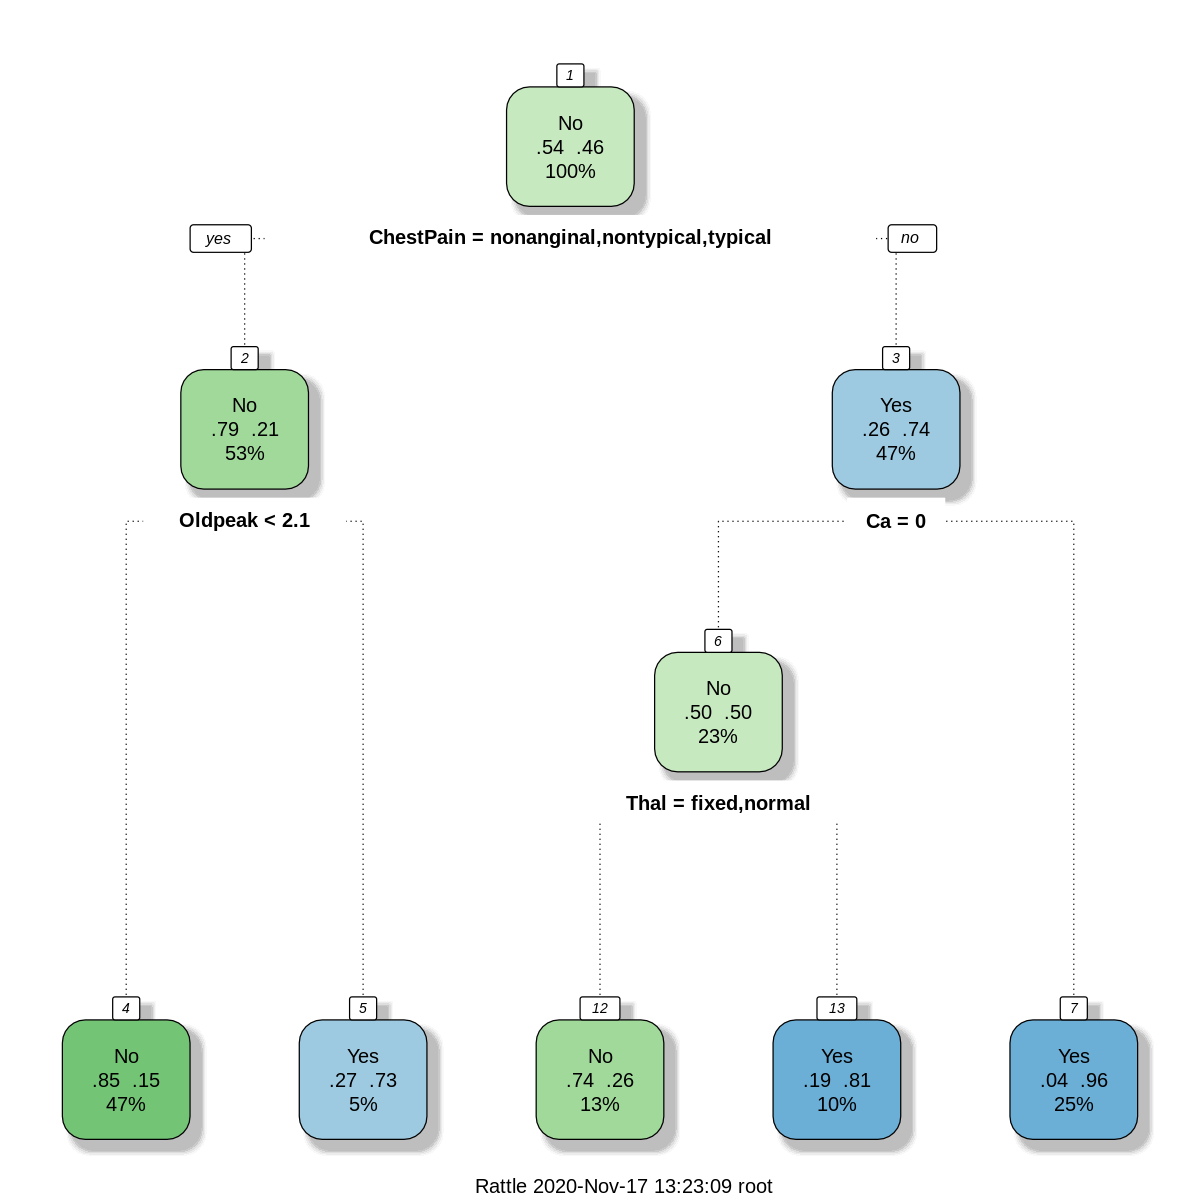

In [25]:
# 가지치기를 통해 노드의 수가 줄어든것을 알 수 있다.

AHD_detection_pr <- rpart::prune(AHD_detection, cp = min_xerror_cp)

fancyRpartPlot(AHD_detection_pr)

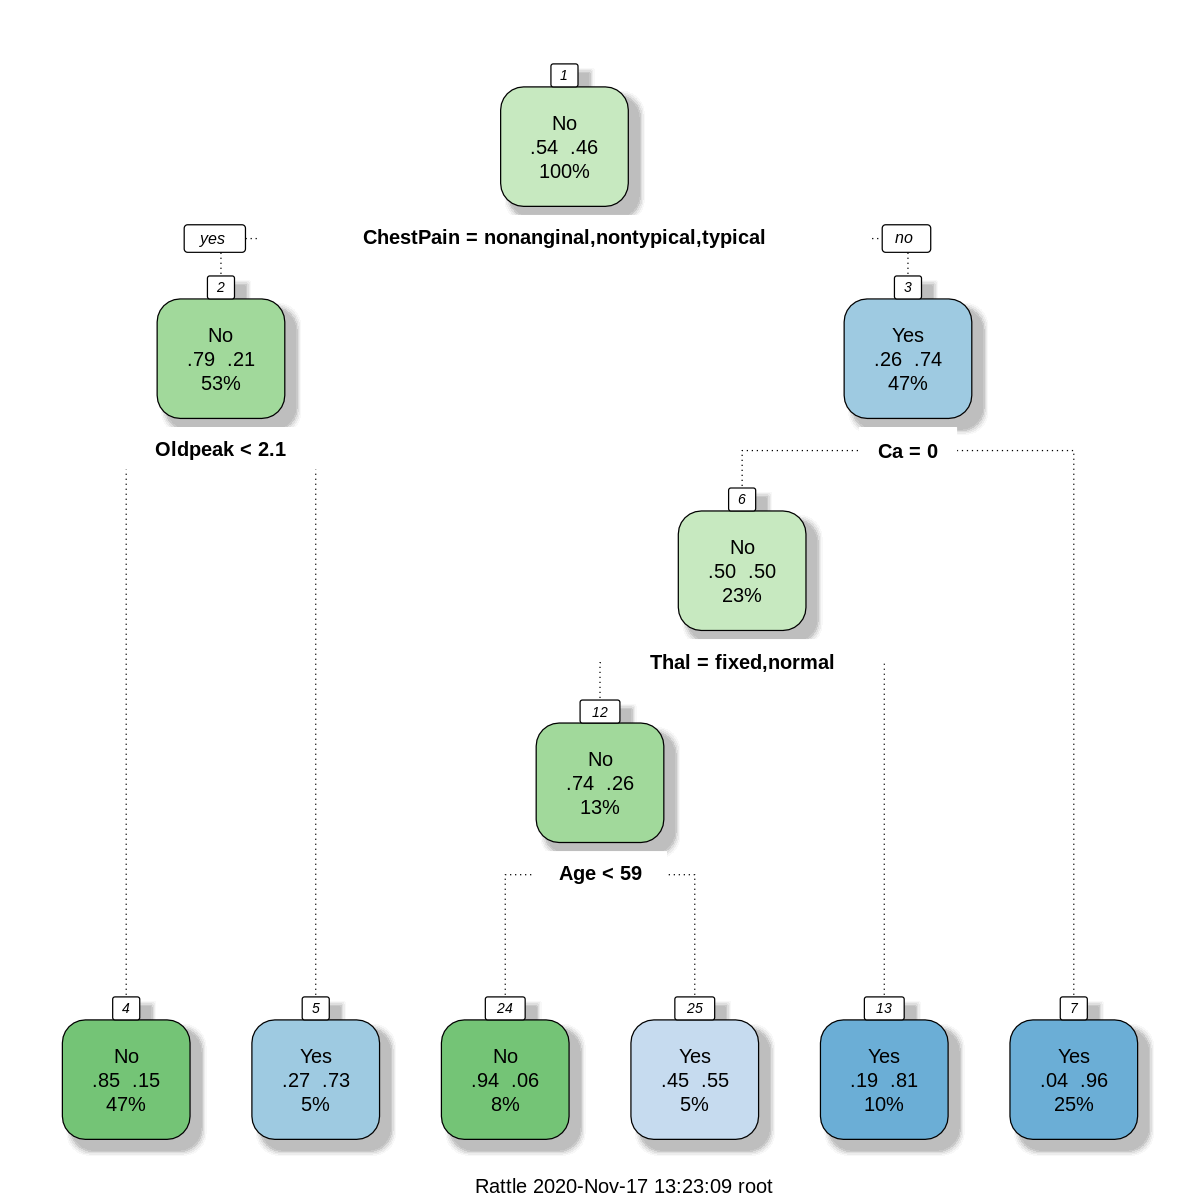

In [26]:
# 이전 그래프
fancyRpartPlot(AHD_detection)

* **test를 이용한 예측 및 평가**

In [27]:
# 테스트 셋으로 모델을 평가 

test %>% show()

# A tibble: 90 x 15
      V1   Age Sex   ChestPain RestBP  Chol Fbs   RestECG MaxHR ExAng Oldpeak
   <int> <int> <fct> <fct>      <int> <int> <fct> <fct>   <int> <fct>   <dbl>
 1     1    63 1     typical      145   233 1     2         150 0         2.3
 2     8    57 0     asymptom…    120   354 0     0         163 1         0.6
 3    10    53 1     asymptom…    140   203 1     2         155 1         3.1
 4    13    56 1     nonangin…    130   256 1     2         142 1         0.6
 5    17    48 1     nontypic…    110   229 0     0         168 0         1  
 6    18    54 1     asymptom…    140   239 0     0         160 0         1.2
 7    19    48 0     nonangin…    130   275 0     0         139 0         0.2
 8    37    43 1     asymptom…    120   177 0     2         120 1         2.5
 9    38    57 1     asymptom…    150   276 0     2         112 1         0.6
10    41    65 0     asymptom…    150   225 0     2         114 0         1  
# … with 80 more rows, and 4 more variables:

In [28]:
# 모델을 이용해 test set의 결과를 예측한다.

predict_value <- predict(AHD_detection_pr, test, type = "class") %>% 
 tibble(predict_value = .)
predict_value %>% show()

# A tibble: 90 x 1
   predict_value
   <fct>        
 1 Yes          
 2 No           
 3 Yes          
 4 No           
 5 No           
 6 No           
 7 No           
 8 Yes          
 9 Yes          
10 Yes          
# … with 80 more rows


In [29]:
# 실제값과 예측값을 비교 
# AHD = 실제 값, predict_value = 예측값

predict_check <- test %>% select(AHD) %>% dplyr::bind_cols(., predict_value) 
predict_check %>% show()

# A tibble: 90 x 2
   AHD   predict_value
   <fct> <fct>        
 1 No    Yes          
 2 No    No           
 3 Yes   Yes          
 4 Yes   No           
 5 Yes   No           
 6 No    No           
 7 No    No           
 8 Yes   Yes          
 9 Yes   Yes          
10 Yes   Yes          
# … with 80 more rows


* Confusion Matrix(실제값과 모델에 의한 분류값을 비교하는 테이블)

![png](https://github.com/Jin0331/TA/blob/master/image/confusion_m.png?raw=true)

https://yamalab.tistory.com/50

In [30]:
# confusion matrix를 이용하면 결과를 더 쉽게 볼 수있다.
# 실제값과 예측값을 넣어줌
# Accuracy : 0.7889 -> 정확도는 78%정도 된다.

cm <- caret::confusionMatrix(predict_value$predict_value, test$AHD)
cm

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  43  13
       Yes  6  28
                                          
               Accuracy : 0.7889          
                 95% CI : (0.6901, 0.8679)
    No Information Rate : 0.5444          
    P-Value [Acc > NIR] : 1.206e-06       
                                          
                  Kappa : 0.5684          
                                          
 Mcnemar's Test P-Value : 0.1687          
                                          
            Sensitivity : 0.8776          
            Specificity : 0.6829          
         Pos Pred Value : 0.7679          
         Neg Pred Value : 0.8235          
             Prevalence : 0.5444          
         Detection Rate : 0.4778          
   Detection Prevalence : 0.6222          
      Balanced Accuracy : 0.7802          
                                          
       'Positive' Class : No              
                                 

In [34]:
#https://stackoverflow.com/questions/23891140/r-how-to-visualize-confusion-matrix-using-the-caret-package
# 그냥 깔끔하게 볼 수 있는 confusion matrix 함수임

draw_confusion_matrix <- function(cm) {

  total <- sum(cm$table)
  res <- as.numeric(cm$table)

  # Generate color gradients. Palettes come from RColorBrewer.
  greenPalette <- c("#F7FCF5","#E5F5E0","#C7E9C0","#A1D99B","#74C476","#41AB5D","#238B45","#006D2C","#00441B")
  redPalette <- c("#FFF5F0","#FEE0D2","#FCBBA1","#FC9272","#FB6A4A","#EF3B2C","#CB181D","#A50F15","#67000D")
  getColor <- function (greenOrRed = "green", amount = 0) {
    if (amount == 0)
      return("#FFFFFF")
    palette <- greenPalette
    if (greenOrRed == "red")
      palette <- redPalette
    colorRampPalette(palette)(100)[10 + ceiling(90 * amount / total)]
  }

  # set the basic layout
  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  classes = colnames(cm$table)
  rect(150, 430, 240, 370, col=getColor("green", res[1]))
  text(195, 435, classes[1], cex=1.2)
  rect(250, 430, 340, 370, col=getColor("red", res[3]))
  text(295, 435, classes[2], cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col=getColor("red", res[2]))
  rect(250, 305, 340, 365, col=getColor("green", res[4]))
  text(140, 400, classes[1], cex=1.2, srt=90)
  text(140, 335, classes[2], cex=1.2, srt=90)

  # add in the cm results
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
}

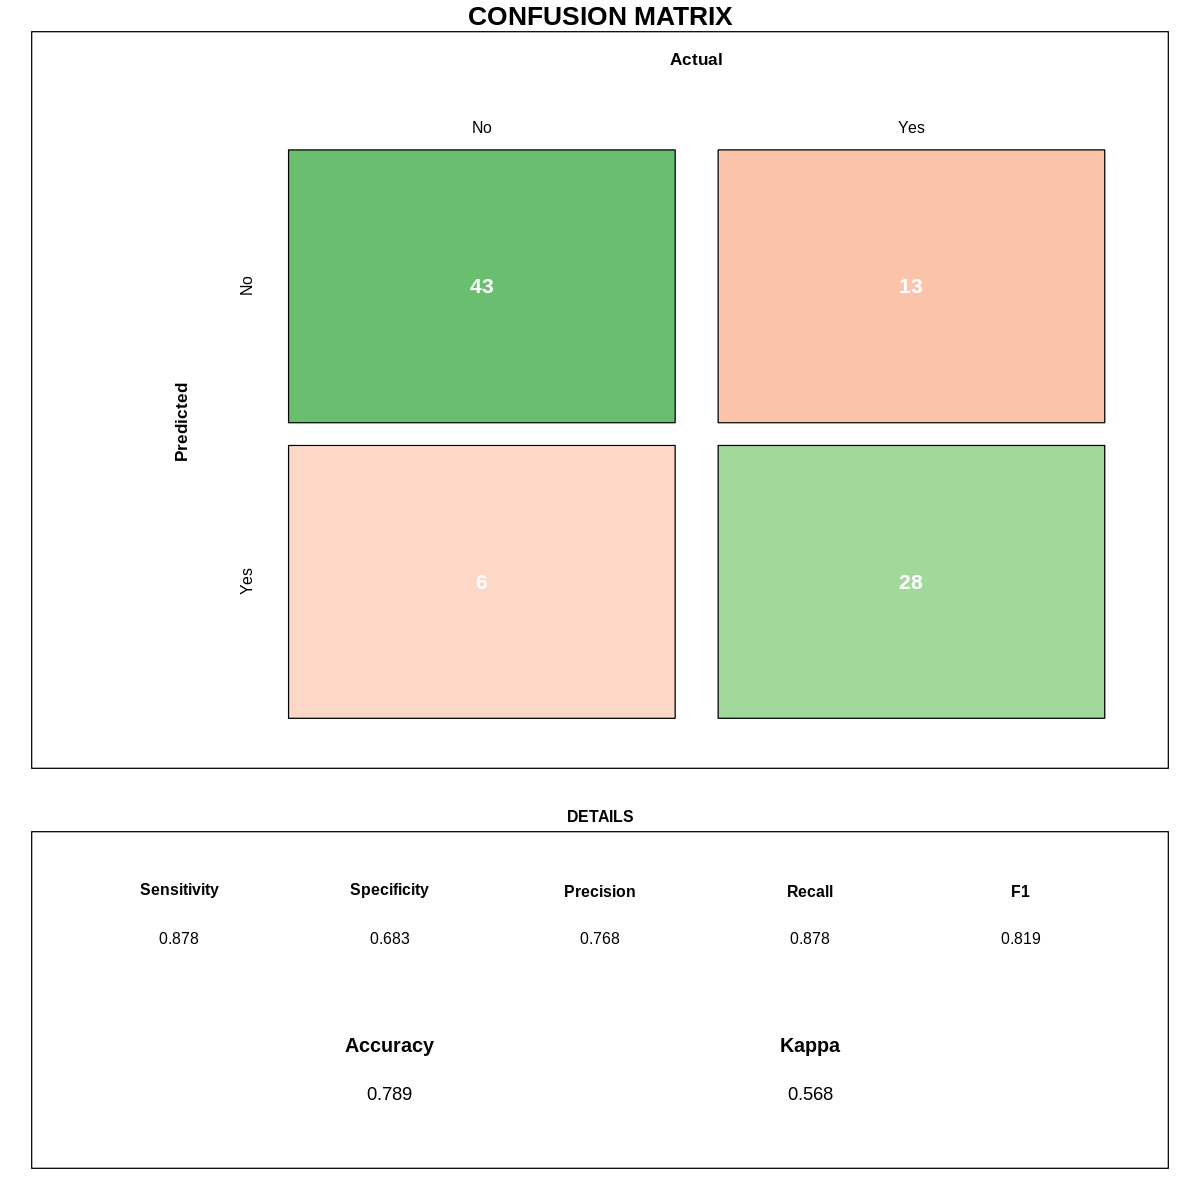

In [35]:
draw_confusion_matrix(cm)

- - -

#### **B. 예제 2 - rpart 패키지 이용**

* https://www.kaggle.com/c/titanic/data

**<kaggle의 타이타닉 data>**

  * survived : 생존=1, 죽음=0
  * pclass : 승객 등급. 1등급=1, 2등급=2, 3등급=3
  * sibsp : 함께 탑승한 형제 또는 배우자 수
  * parch : 함께 탑승한 부모 또는 자녀 수
  * ticket : 티켓 번호
  * cabin : 선실 번호
  * embarked : 탑승장소 S=Southhampton, C=Cherbourg, Q=Queenstown

In [36]:
train <- fread("https://raw.githubusercontent.com/Jin0331/TA/master/data/titanic/train.csv") %>%
 as_tibble()

In [37]:
str(train)

tibble [891 × 12] (S3: tbl_df/tbl/data.frame)
 $ PassengerId: int [1:891] 1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int [1:891] 0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int [1:891] 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr [1:891] "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr [1:891] "male" "female" "female" "female" ...
 $ Age        : num [1:891] 22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int [1:891] 1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int [1:891] 0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr [1:891] "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num [1:891] 7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr [1:891] "" "C85" "" "C123" ...
 $ Embarked   : chr [1:891] "S" "C" "S" "S" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [38]:
# 결측치가 있는것을 알 수 있다.

train %>% summary()

  PassengerId       Survived          Pclass          Name          
 Min.   :  1.0   Min.   :0.0000   Min.   :1.000   Length:891        
 1st Qu.:223.5   1st Qu.:0.0000   1st Qu.:2.000   Class :character  
 Median :446.0   Median :0.0000   Median :3.000   Mode  :character  
 Mean   :446.0   Mean   :0.3838   Mean   :2.309                     
 3rd Qu.:668.5   3rd Qu.:1.0000   3rd Qu.:3.000                     
 Max.   :891.0   Max.   :1.0000   Max.   :3.000                     
                                                                    
     Sex                 Age            SibSp           Parch       
 Length:891         Min.   : 0.42   Min.   :0.000   Min.   :0.0000  
 Class :character   1st Qu.:20.12   1st Qu.:0.000   1st Qu.:0.0000  
 Mode  :character   Median :28.00   Median :0.000   Median :0.0000  
                    Mean   :29.70   Mean   :0.523   Mean   :0.3816  
                    3rd Qu.:38.00   3rd Qu.:1.000   3rd Qu.:0.0000  
                    Max.   :80.00 

* 범주형 변수 확인

In [39]:
# 범주형 변수로 바꿔주고
# 모델 만들때 필요하지 않은 요소들을 제거해준다. 

train <- train %>% 
 select(-PassengerId, -Name, -Cabin, -Ticket) %>% mutate_at(c("Survived","Sex","Embarked", "Pclass"), factor)
summary(train)

 Survived Pclass      Sex           Age            SibSp           Parch       
 0:549    1:216   female:314   Min.   : 0.42   Min.   :0.000   Min.   :0.0000  
 1:342    2:184   male  :577   1st Qu.:20.12   1st Qu.:0.000   1st Qu.:0.0000  
          3:491                Median :28.00   Median :0.000   Median :0.0000  
                               Mean   :29.70   Mean   :0.523   Mean   :0.3816  
                               3rd Qu.:38.00   3rd Qu.:1.000   3rd Qu.:0.0000  
                               Max.   :80.00   Max.   :8.000   Max.   :6.0000  
                               NA's   :177                                     
      Fare        Embarked
 Min.   :  0.00    :  2   
 1st Qu.:  7.91   C:168   
 Median : 14.45   Q: 77   
 Mean   : 32.20   S:644   
 3rd Qu.: 31.00           
 Max.   :512.33           
                          

* Hmisc::impute을 이용한 NA 값 대체(평균, 중앙값, 특정 숫자)

* https://m.blog.naver.com/PostView.nhn?blogId=tjdudwo93&logNo=221142961499&proxyReferer=https:%2F%2Fwww.google.com%2F

In [40]:
install.packages("Hmisc")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘png’, ‘jpeg’, ‘checkmate’, ‘Formula’, ‘latticeExtra’, ‘gridExtra’, ‘htmlTable’, ‘viridis’




In [41]:
# 결측치를 평균으로 대체하기 위해서 패키지를 쓴다.
# impute를 이용해서 쉽게 처리할 수 있다.

library(Hmisc)
train$Age <- impute(train$Age, median)

Loading required package: survival


Attaching package: ‘survival’


The following object is masked from ‘package:caret’:

    cluster


Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units




In [42]:
train %>% summary()


 177 values imputed to 28 



 Survived Pclass      Sex           Age            SibSp           Parch       
 0:549    1:216   female:314   Min.   : 0.42   Min.   :0.000   Min.   :0.0000  
 1:342    2:184   male  :577   1st Qu.:22.00   1st Qu.:0.000   1st Qu.:0.0000  
          3:491                Median :28.00   Median :0.000   Median :0.0000  
                               Mean   :29.36   Mean   :0.523   Mean   :0.3816  
                               3rd Qu.:35.00   3rd Qu.:1.000   3rd Qu.:0.0000  
                               Max.   :80.00   Max.   :8.000   Max.   :6.0000  
      Fare        Embarked
 Min.   :  0.00    :  2   
 1st Qu.:  7.91   C:168   
 Median : 14.45   Q: 77   
 Mean   : 32.20   S:644   
 3rd Qu.: 31.00           
 Max.   :512.33           

* **train을 이용한 Decision Tree 모델 생성**

In [43]:
# 결정트리 모델을 만들어준다. 

set.seed(29)
library(rpart)
Survived_detection <- rpart(formula = Survived ~ ., data = train, method = "class")
Survived_detection$cptable %>% as_tibble() %>%
  filter(xerror == min(xerror)) %>% pull(CP)

[1] 0.01461988 0.01000000

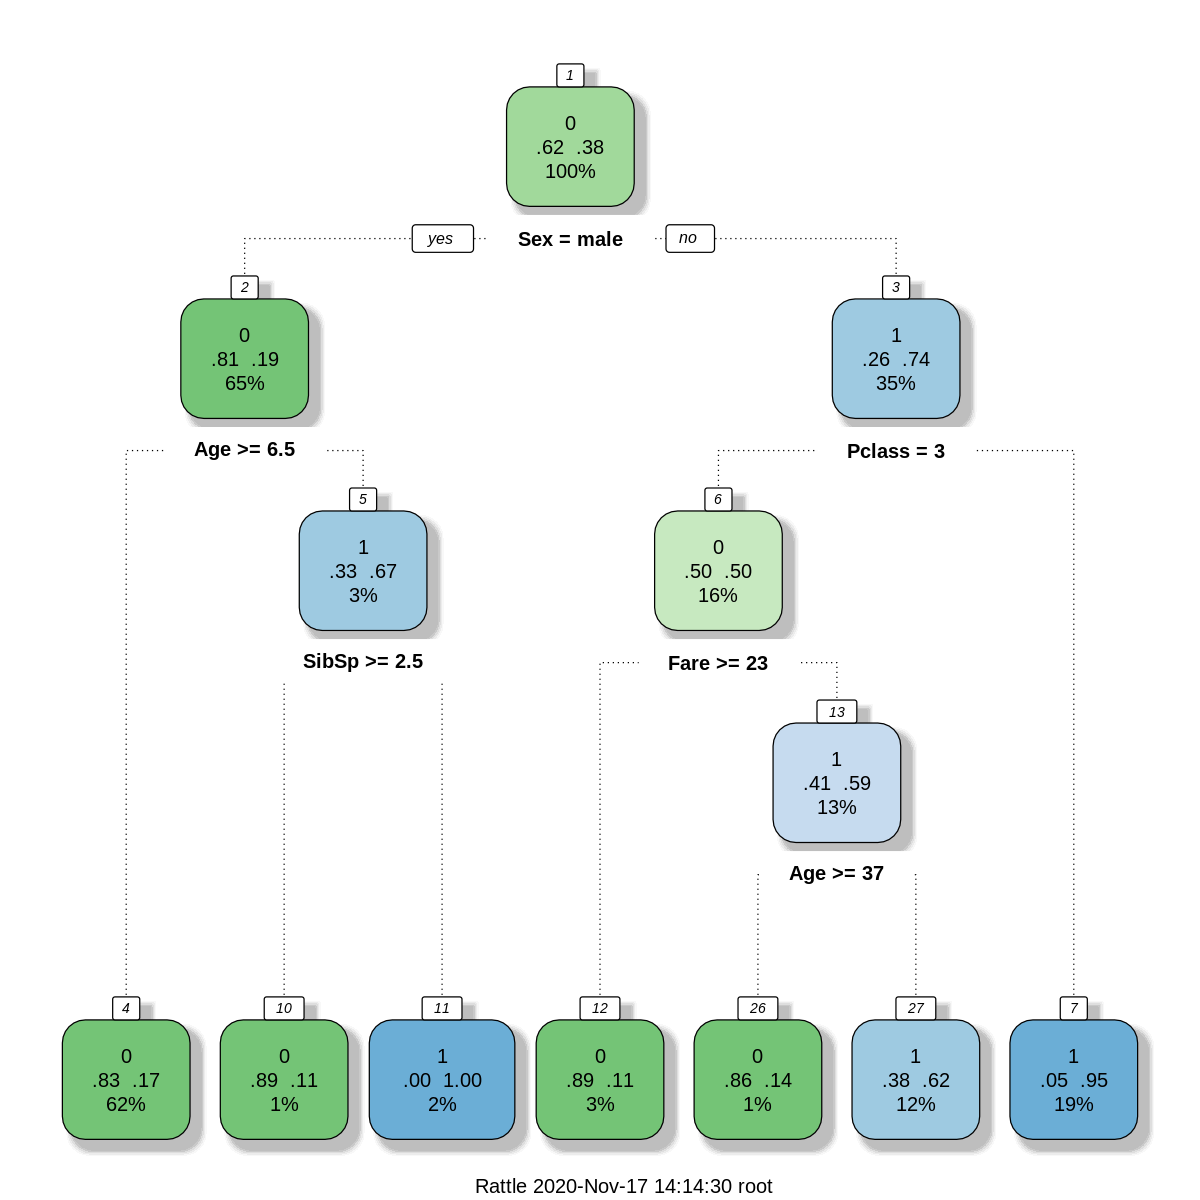

In [44]:
# plotting
fancyRpartPlot(Survived_detection)

* pruning

In [45]:
# 가지치기를 하기 위해서 printcp()를 이용한다. 
# xerror의 최솟값이 되는 CP를 찾으면 된다. -> 필요없는 특징으로, 가지치기 대상이됨

printcp(Survived_detection)


Classification tree:
rpart(formula = Survived ~ ., data = train, method = "class")

Variables actually used in tree construction:
[1] Age    Fare   Pclass Sex    SibSp 

Root node error: 342/891 = 0.38384

n= 891 

        CP nsplit rel error  xerror     xstd
1 0.444444      0   1.00000 1.00000 0.042446
2 0.030702      1   0.55556 0.55556 0.035750
3 0.023392      3   0.49415 0.53509 0.035260
4 0.020468      4   0.47076 0.52339 0.034970
5 0.014620      5   0.45029 0.51462 0.034749
6 0.010000      6   0.43567 0.51462 0.034749


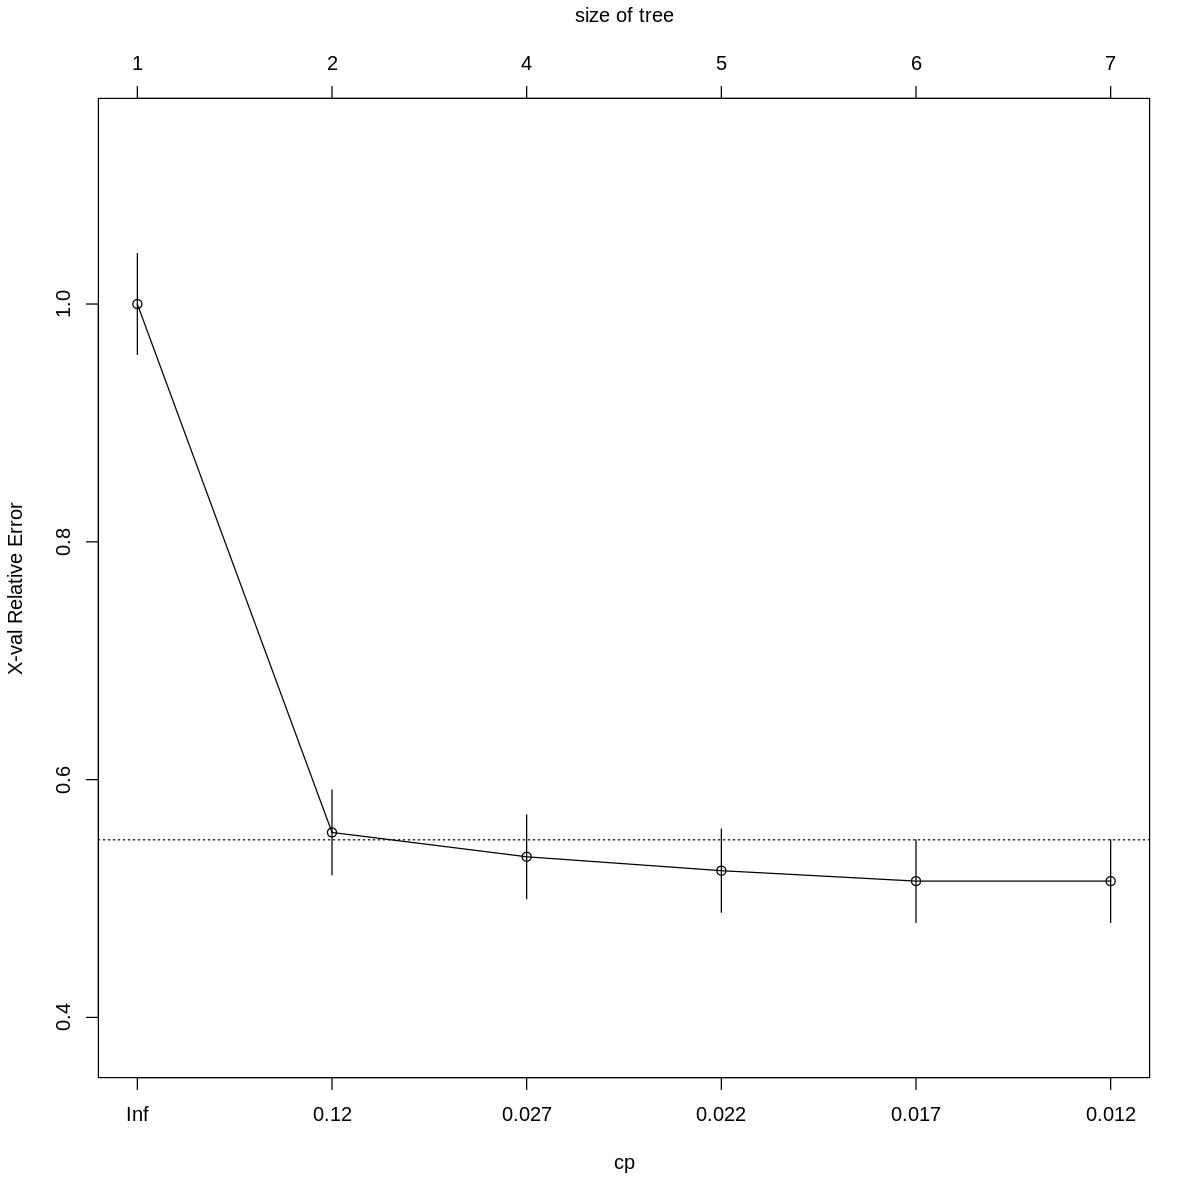

In [46]:
plotcp(Survived_detection)

In [47]:
# filter를 이용해서 xerror가 최솟값되는 CP를 찾음

min_xerror_cp <- Survived_detection$cptable %>% as_tibble() %>%
  filter(xerror == min(xerror)) %>% pull(CP)

In [48]:
# 최솟값이 2개가 나옴

min_xerror_cp

[1] 0.01461988 0.01000000

In [49]:
# 최솟값이 2개가 나와서 

Survived_detection_pr1 <- rpart::prune(Survived_detection, cp = min_xerror_cp[1])# 노드가 하나 지워진것을 알 수 있다.
Survived_detection_pr2 <- rpart::prune(Survived_detection, cp = min_xerror_cp[2])# 기존노드와 차이가 없다->기존노드가 최적화 되어있다.

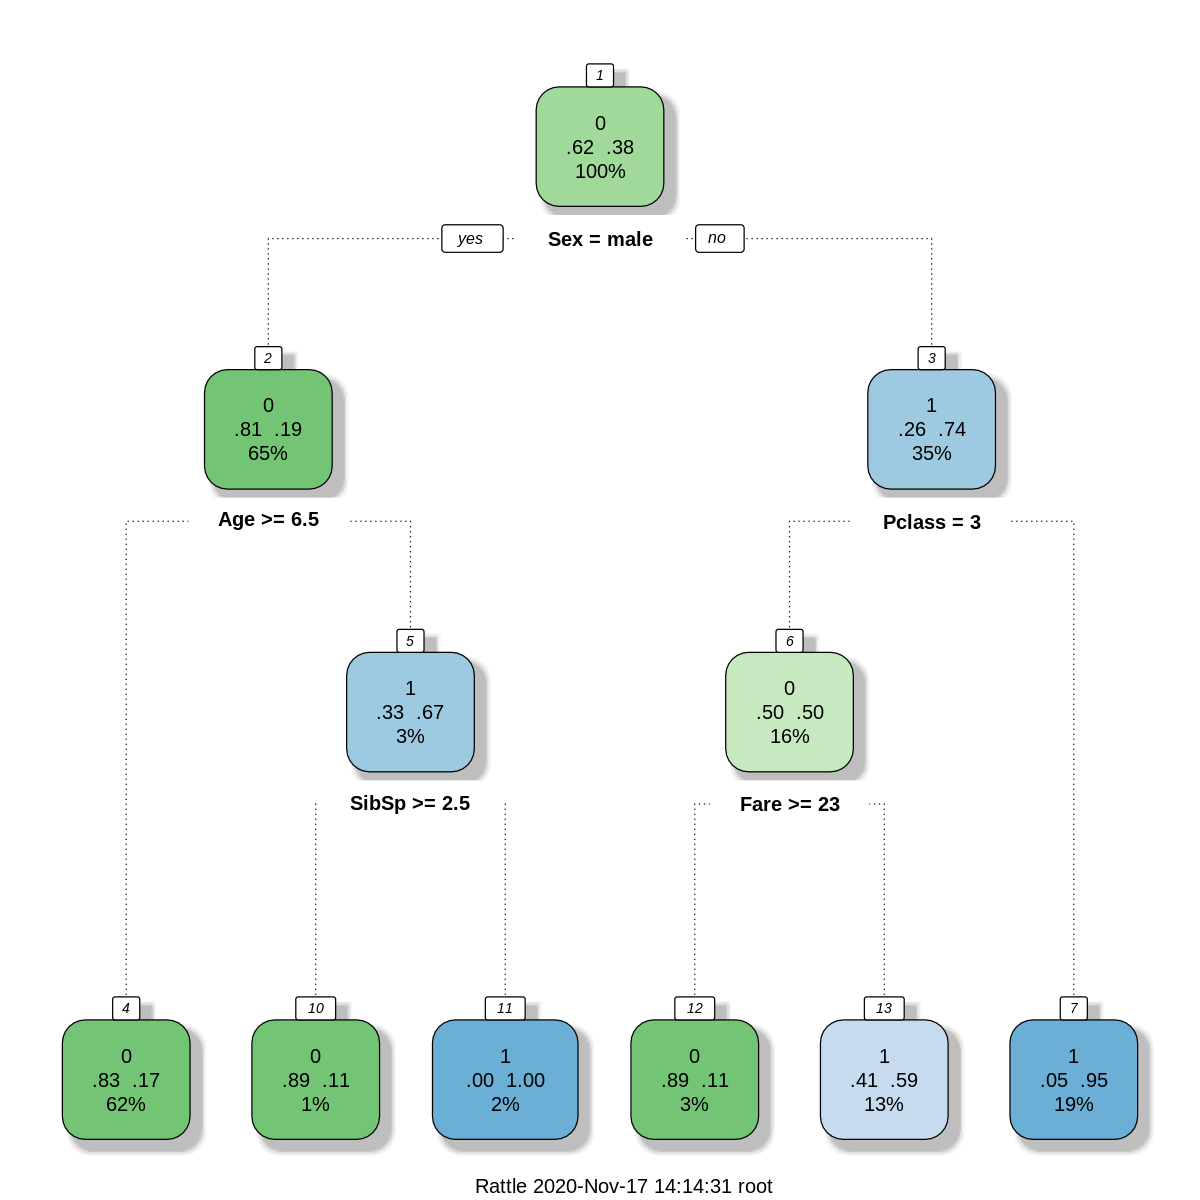

In [50]:
fancyRpartPlot(Survived_detection_pr1)

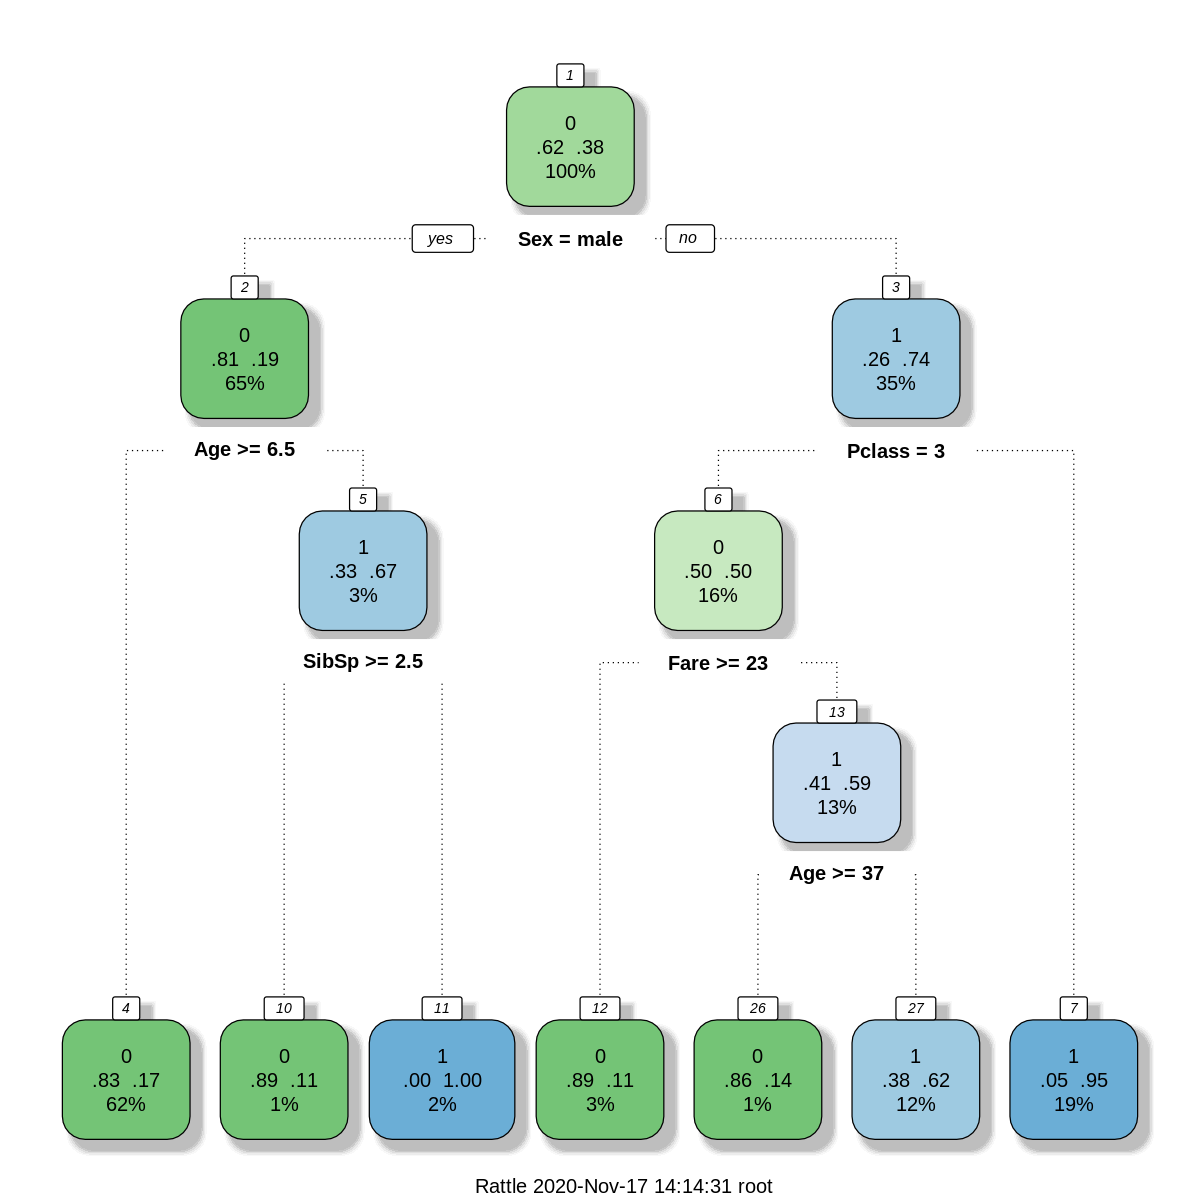

In [51]:
fancyRpartPlot(Survived_detection_pr2)

* 생성한 2개의 Decision Tree 모델을 이용하여 kaggle에 제출 및 평가받기

In [52]:
# 모델을 이용해서 kaggle에 제출 및 평가받기

test <- fread("https://raw.githubusercontent.com/Jin0331/TA/master/data/titanic/test.csv", sep = ",") %>% as_tibble()
test %>% summary()

  PassengerId         Pclass          Name               Sex           
 Min.   : 892.0   Min.   :1.000   Length:418         Length:418        
 1st Qu.: 996.2   1st Qu.:1.000   Class :character   Class :character  
 Median :1100.5   Median :3.000   Mode  :character   Mode  :character  
 Mean   :1100.5   Mean   :2.266                                        
 3rd Qu.:1204.8   3rd Qu.:3.000                                        
 Max.   :1309.0   Max.   :3.000                                        
                                                                       
      Age            SibSp            Parch           Ticket         
 Min.   : 0.17   Min.   :0.0000   Min.   :0.0000   Length:418        
 1st Qu.:21.00   1st Qu.:0.0000   1st Qu.:0.0000   Class :character  
 Median :27.00   Median :0.0000   Median :0.0000   Mode  :character  
 Mean   :30.27   Mean   :0.4474   Mean   :0.3923                     
 3rd Qu.:39.00   3rd Qu.:1.0000   3rd Qu.:0.0000                     
 Max

* NA 값 추정(median)

In [53]:
# 결측치를 제거해줌

test$Age <- impute(test$Age, median)
test$Fare <- impute(test$Age, median)
test %>% summary()


 86 values imputed to 27 


 86 values imputed to 27 



  PassengerId         Pclass          Name               Sex           
 Min.   : 892.0   Min.   :1.000   Length:418         Length:418        
 1st Qu.: 996.2   1st Qu.:1.000   Class :character   Class :character  
 Median :1100.5   Median :3.000   Mode  :character   Mode  :character  
 Mean   :1100.5   Mean   :2.266                                        
 3rd Qu.:1204.8   3rd Qu.:3.000                                        
 Max.   :1309.0   Max.   :3.000                                        
      Age            SibSp            Parch           Ticket         
 Min.   : 0.17   Min.   :0.0000   Min.   :0.0000   Length:418        
 1st Qu.:23.00   1st Qu.:0.0000   1st Qu.:0.0000   Class :character  
 Median :27.00   Median :0.0000   Median :0.0000   Mode  :character  
 Mean   :29.60   Mean   :0.4474   Mean   :0.3923                     
 3rd Qu.:35.75   3rd Qu.:1.0000   3rd Qu.:0.0000                     
 Max.   :76.00   Max.   :8.0000   Max.   :9.0000                     
      

* 범주형 변수

In [54]:
test <- test %>% 
 select(-Name, -Cabin, -Ticket) %>% mutate_at(c("Sex","Embarked", "Pclass"), factor)
summary(test)


 86 values imputed to 27 


 86 values imputed to 27 



  PassengerId     Pclass      Sex           Age            SibSp       
 Min.   : 892.0   1:107   female:152   Min.   : 0.17   Min.   :0.0000  
 1st Qu.: 996.2   2: 93   male  :266   1st Qu.:23.00   1st Qu.:0.0000  
 Median :1100.5   3:218                Median :27.00   Median :0.0000  
 Mean   :1100.5                        Mean   :29.60   Mean   :0.4474  
 3rd Qu.:1204.8                        3rd Qu.:35.75   3rd Qu.:1.0000  
 Max.   :1309.0                        Max.   :76.00   Max.   :8.0000  
     Parch             Fare       Embarked
 Min.   :0.0000   Min.   : 0.17   C:102   
 1st Qu.:0.0000   1st Qu.:23.00   Q: 46   
 Median :0.0000   Median :27.00   S:270   
 Mean   :0.3923   Mean   :29.60           
 3rd Qu.:0.0000   3rd Qu.:35.75           
 Max.   :9.0000   Max.   :76.00           

* 예측(Survived_detection_pr 모델)

In [55]:
# pruning 모델 1
predict_value <- predict(Survived_detection_pr1, test, type = "class") %>% tibble(Survived = .)
submission_pr1 <- test %>% select(PassengerId) %>% dplyr::bind_cols(., predict_value)

# pruning 모델 2
predict_value <- predict(Survived_detection_pr2, test, type = "class") %>% tibble(Survived = .)
submission_pr2 <- test %>% select(PassengerId) %>% dplyr::bind_cols(., predict_value)

In [56]:
submission_pr1 %>% head(20)

PassengerId,Survived
<int>,<fct>
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,1


In [57]:
submission_pr2 %>% head(20)

PassengerId,Survived
<int>,<fct>
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,1


In [58]:
 # write
 submission_pr1 %>% write_csv(path = "submission_pr1.csv")
 submission_pr2 %>% write_csv(path = "submission_pr2.csv")

Warning message:
“The `path` argument of `write_csv()` is deprecated as of readr 1.4.0.
Please use the `file` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
